In [1]:
!pip install -qU pip awscli boto3 sagemaker
!pip install nvidia-pyindex
!pip install tritonclient[http]

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.29.22 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 237.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
tensorflow 

### To create the JIT Trace model you need

Torch version 1.12.1 Torch Vision 0.13.1 and Cuda library 11.3

Secondly you need a GPU instance to run the notebook - this has been tested on a ml.g4dn.xlarge which comes with 1 gpu

In [5]:
pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://pypi.ngc.nvidia.com, https://download.pytorch.org/whl/cu113
     ━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/1.8 GB 9.8 MB/s eta 0:02:41ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device

     ━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/1.8 GB 9.5 MB/s eta 0:02:46
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os 
import tarfile
import boto3, json, sagemaker, time
from sagemaker import get_execution_role
import concurrent.futures
import time

### OPTIONAL -- Create a JIT Traced model

#### Few points to note: The traced models is provided in the zip file which can be used as is
1. The Model after trace is now returing outputs like OUTPUT_0 , 1 etc
2. To change them to named outputs can be done and we can try post this issue gets resolved
3. To full create a jit traced model we will need to provide a sample inputs and hence for now we have created a scripted model
4. The TORCH and the TORCHSCRIPT libraries would need to match the container and hence we use the specific ones mentioned above

In [7]:
import torch
from pathlib import Path
print(torch.__version__)
import torchvision
print(torchvision.__version__)


1.8.0
0.9.0


In [8]:
torch.cuda.is_available()

True

**Convert the model into Serving mode**

In [9]:
i = torch.ones((5, 3), dtype=torch.int16)
print(i)

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]], dtype=torch.int16)


In [10]:
#%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./temp-data', train=True,
                                        download=True, transform=transform)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./temp-data/cifar-10-python.tar.gz to ./temp-data


In [11]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=False, num_workers=2)

plane  bird horse   dog


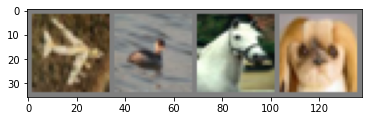

In [12]:
import matplotlib.pyplot as plt
import numpy as np



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
#%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.203
[1,  4000] loss: 1.871
[1,  6000] loss: 1.689
[1,  8000] loss: 1.640
[1, 10000] loss: 1.559
[1, 12000] loss: 1.503
[2,  2000] loss: 1.431
[2,  4000] loss: 1.398
[2,  6000] loss: 1.371
[2,  8000] loss: 1.336
[2, 10000] loss: 1.306
[2, 12000] loss: 1.255
Finished Training


In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [17]:
for data in testloader:
    print(type(data), len(data), data[0].shape)
    one_data = data[0]
    break

<class 'list'> 2 torch.Size([4, 3, 32, 32])


In [18]:
traced_cell = torch.jit.trace(net, one_data)

In [19]:
traced_cell.save("default-nn-img-model.pt")

In [20]:
load_traced_cell = torch.load('default-nn-img-model.pt')

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/torch/serialization.py:587: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [21]:
load_traced_cell(one_data)

tensor([[-3.3564, -2.8079,  1.3642,  2.5126,  0.7921,  2.0956,  3.7282,  0.7113,
         -3.8439, -2.3251],
        [ 1.6004,  1.8039, -1.2895, -1.0506, -2.5624, -1.3921, -4.1758, -0.0870,
          1.2149,  4.5517],
        [ 2.3604,  0.5419, -0.9982, -0.6536, -1.9622, -1.6786, -2.6169, -0.5829,
          1.0040,  3.6717],
        [-2.0356, -1.7313,  0.5480,  0.5447,  3.1081,  0.9937,  3.5059,  0.4722,
         -4.2191, -1.7662]], grad_fn=<AddBackward0>)

In [23]:
ones = torch.ones(2, 3)
print(ones)

twos = torch.ones(2, 3) * 2 # every element is multiplied by 2
print(twos)

threes = ones + twos       # addition allowed because shapes are similar
print(threes)              # tensors are added element-wise
print(threes.shape)        # this has the same dimensions as input tensors

r1 = torch.rand(2, 3)
r2 = torch.rand(3, 2)
 
torch.concat([r1,r2])

r3 = torch.stack([r1,r2]) # -- size is different so will not stack
r3

# uncomment this line to get a runtime error
# r3 = r1 + r2

tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[2., 2., 2.],
        [2., 2., 2.]])
tensor([[3., 3., 3.],
        [3., 3., 3.]])
torch.Size([2, 3])


AttributeError: module 'torch' has no attribute 'concat'

In [ ]:
print('hello')

In [42]:
def euclidian_distance(a, b):
    return np.sqrt(np.sum((a-b)**2, axis=1))

import numpy as np

a_1 = np.ones( (2,3), dtype=float)
a_2 = np.ones( (2,3), dtype=int)

result = euclidian_distance(a_1, a_2)
result

array([0., 0.])

In [39]:
result.shape

(2,)

In [24]:
!pip install transformers[torch]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://pypi.ngc.nvidia.com


In [25]:
from transformers import BertModel, BertTokenizer, BertConfig
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
sample = 'where is Himalayas in the world map?'
encoding = tokenizer.encode(sample)
print(encoding)
print(tokenizer.convert_ids_to_tokens(encoding))

[101, 2073, 2003, 26779, 1999, 1996, 2088, 4949, 1029, 102]
['[CLS]', 'where', 'is', 'himalayas', 'in', 'the', 'world', 'map', '?', '[SEP]']


In [27]:
sample = 'where is Himalayass in the world map?'
encoding = tokenizer.encode(sample)
print(encoding)
print(tokenizer.convert_ids_to_tokens(encoding))

[101, 2073, 2003, 26779, 2015, 1999, 1996, 2088, 4949, 1029, 102]
['[CLS]', 'where', 'is', 'himalayas', '##s', 'in', 'the', 'world', 'map', '?', '[SEP]']


In [28]:
q1 = 'Who was Tony Stark?'
c1 = 'Anthony Edward Stark known as Tony Stark is a fictional character in Avengers'
encoding = tokenizer.encode_plus( q1, c1)
for key, value in encoding.items():
    print( '{} : {}'.format( key, value ) )

input_ids : [101, 2040, 2001, 4116, 9762, 1029, 102, 4938, 3487, 9762, 2124, 2004, 4116, 9762, 2003, 1037, 7214, 2839, 1999, 14936, 102]
token_type_ids : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### With Padding is true so we can get uniform length output

In [29]:
q1 = 'Who was Tony Stark?'
c1 = 'Anthony Edward Stark known as Tony Stark is a fictional character in Avengers'
q2 = 'Who was Tony in Marvel'
c2 = 'Tony Stark is a fictional character in Marvel Avengers'
encoding = tokenizer([q1,q2], [c1,c2])
for key, value in encoding.items():
    print('1- {}: {}'.format(key, value))

1- input_ids: [[101, 2040, 2001, 4116, 9762, 1029, 102, 4938, 3487, 9762, 2124, 2004, 4116, 9762, 2003, 1037, 7214, 2839, 1999, 14936, 102], [101, 2040, 2001, 4116, 1999, 8348, 102, 4116, 9762, 2003, 1037, 7214, 2839, 1999, 8348, 14936, 102]]
1- token_type_ids: [[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
1- attention_mask: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [30]:
encoding

{'input_ids': [[101, 2040, 2001, 4116, 9762, 1029, 102, 4938, 3487, 9762, 2124, 2004, 4116, 9762, 2003, 1037, 7214, 2839, 1999, 14936, 102], [101, 2040, 2001, 4116, 1999, 8348, 102, 4116, 9762, 2003, 1037, 7214, 2839, 1999, 8348, 14936, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [42]:
encoding = tokenizer.batch_encode_plus([[q1,c1], [q2,c2]], padding=True)
for key, value in encoding.items():
    print('{}: {}'.format(key, value))

input_ids: [[101, 2040, 2001, 4116, 9762, 1029, 102, 4938, 3487, 9762, 2124, 2004, 4116, 9762, 2003, 1037, 7214, 2839, 1999, 14936, 102], [101, 2040, 2001, 4116, 1999, 8348, 102, 4116, 9762, 2003, 1037, 7214, 2839, 1999, 8348, 14936, 102, 0, 0, 0, 0]]
token_type_ids: [[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]
attention_mask: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]


In [126]:
q1 = 'Who was Tony Stark?'
c1 = 'Anthony Edward Stark known as Tony Stark is a fictional character in Avengers'
q2 = 'Who was Tony in Marvel'
c2 = 'Tony Stark is a fictional character in Marvel Avengers'
encoding = tokenizer([q1,q2])
for key, value in encoding.items():
    print('1- {}: {}'.format(key, value))

1- input_ids: [[101, 2040, 2001, 4116, 9762, 1029, 102], [101, 2040, 2001, 4116, 1999, 8348, 102]]
1- token_type_ids: [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]
1- attention_mask: [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]


In [128]:
encoding = tokenizer.batch_encode_plus([[q1,q2]], padding=True)
for key, value in encoding.items():
    print('{}: {}'.format(key, value))

input_ids: [[101, 2040, 2001, 4116, 9762, 1029, 102, 2040, 2001, 4116, 1999, 8348, 102]]
token_type_ids: [[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]]
attention_mask: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [48]:
import transformers
transformers.__version__

'4.22.2'

#### Tokenize -- tensors variable length and batch

In [76]:
batch_list = ["Amazon.com is the best ", "DJL is the best serving model", "deepspeed works best",]
batch_list = ['Who was Tony Stark?', 'Who was Tony in Marvel', 'guess who Tony is']

tokenizer_batch = BertTokenizer.from_pretrained("bert-base-uncased", add_prefix_space=True)

tokenizer(batch_list, return_tensors="pt",padding=True) #padding=bool('True'))

{'input_ids': tensor([[ 101, 2040, 2001, 4116, 9762, 1029,  102],
        [ 101, 2040, 2001, 4116, 1999, 8348,  102],
        [ 101, 3984, 2040, 4116, 2003,  102,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0]])}

In [77]:
len(tokenizer(batch_list, return_tensors="pt",padding=True))

3

### Different BERT require different input 

For example, DistilBERT does not use token_type_ids it reduces the layers by a factor of two. These changes made the model much faster than BERT with a little bit of compromise to score. Let’s see DistilBERT tokenizer example


In [32]:
from transformers import DistilBertTokenizer
tokenizer_distill= DistilBertTokenizer.from_pretrained('distilbert-base-uncased') 

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [33]:

encoding_distill = tokenizer_distill.batch_encode_plus([[q1,c1], [q2,c2]], padding=True)
for key, value in encoding_distill.items():
    print('{}: {}'.format(key, value))

input_ids: [[101, 2040, 2001, 4116, 9762, 1029, 102, 4938, 3487, 9762, 2124, 2004, 4116, 9762, 2003, 1037, 7214, 2839, 1999, 14936, 102], [101, 2040, 2001, 4116, 1999, 8348, 102, 4116, 9762, 2003, 1037, 7214, 2839, 1999, 8348, 14936, 102, 0, 0, 0, 0]]
attention_mask: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]


In [34]:
encoding_distill

{'input_ids': [[101, 2040, 2001, 4116, 9762, 1029, 102, 4938, 3487, 9762, 2124, 2004, 4116, 9762, 2003, 1037, 7214, 2839, 1999, 14936, 102], [101, 2040, 2001, 4116, 1999, 8348, 102, 4116, 9762, 2003, 1037, 7214, 2839, 1999, 8348, 14936, 102, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]}

### KNN implementation

In [69]:
#Importing the required modules
import numpy as np
from scipy.stats import mode
 
class KnnImpl:
    def __init__(self, x_train_file, y_file):
        self.x_train_file = x_train_file
        self.y_train_file = y_file
    
    #Euclidean Distance
    def eucledian(self, p1,p2):
        dist = np.sqrt(np.sum((p1-p2)**2))
        return dist
 
    #Function to calculate KNN
    def predict(self, x_input, k):
        op_labels = []
        
        X_train_mem = np.lib.format.open_memmap(self.x_train_file)
        print(X_train_mem.shape)

        y_train_mem = np.lib.format.open_memmap(self.y_train_file)

        #Loop through the Datapoints to be classified
        for item in x_input: 

            #Array to store distances
            point_dist = []

            #Loop through each training Data
            for j in range(len(X_train_mem)): 
                distances = self.eucledian(np.array(X_train_mem[j,:]) , item) 
                #Calculating the distance
                point_dist.append(distances) 
            point_dist = np.array(point_dist) 

            #Sorting the array while preserving the index
            #Keeping the first K datapoints
            dist = np.argsort(point_dist)[:k] 

            #Labels of the K datapoints from above
            labels = y_train_mem[dist]

            #Majority voting
            lab = mode(labels) 
            lab = lab.mode[0]
            op_labels.append(lab)

        return op_labels

In [70]:
#Importing the required modules
#Importing required modules
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from numpy.random import randint
 
#Loading the Data
iris= load_iris()
 
# Store features matrix in X
X= iris.data
#Store target vector in 
y= iris.target
 
 

# Creating the training Data
train_idx =  randint(0,150,100)
X_train = X[train_idx]
y_train = y[train_idx]
 
#Creating the testing Data
test_idx = randint(0,150,50) #taking 50 random samples
X_test = X[test_idx]
y_test = y[test_idx]
 


In [71]:
!mkdir -p temp-data/numpy

In [72]:
np.save('./temp-data/numpy/X_train.npy', X_train)
X_train_mem = np.lib.format.open_memmap('./temp-data/numpy/X_train.npy')
print(X_train_mem.shape)

np.save('./temp-data/numpy/y_train.npy', y_train)
y_train_mem = np.lib.format.open_memmap('./temp-data/numpy/y_train.npy')
print(y_train_mem.shape)


(100, 4)
(100,)


In [82]:
np.repeat(X_train, repeats = [100]*100, axis=0).shape # create 10k rows

(10000, 4)

#### Create a larger data set by repeating rows in numpy

In [96]:
X_train_large = np.repeat(X_train, repeats = [100000]*100, axis=0) # create 10k rows - 100 m rows
np.save('./temp-data/numpy/X_train.npy', X_train_large)

y_train_large = np.repeat(y_train, repeats = [100000]*100, axis=0) # create 10k rows
np.save('./temp-data/numpy/y_train.npy', y_train_large)

X_train_mem = np.lib.format.open_memmap('./temp-data/numpy/X_train.npy')
print(X_train_mem.shape)

y_train_mem = np.lib.format.open_memmap('./temp-data/numpy/y_train.npy')
print(y_train_mem.shape)

(10000000, 4)
(10000000,)


In [97]:
!ls -alrt ./temp-data/numpy

total 390644
drwxrwxr-x 4 ec2-user ec2-user      4096 Dec  4 07:33 ..
drwxrwxr-x 2 ec2-user ec2-user      4096 Dec  4 07:37 .
-rw-rw-r-- 1 ec2-user ec2-user 320000128 Dec  4 23:03 X_train.npy
-rw-rw-r-- 1 ec2-user ec2-user  80000128 Dec  4 23:03 y_train.npy


In [ ]:
%%time
knn_impl = KnnImpl('./temp-data/numpy/X_train.npy', './temp-data/numpy/y_train.npy')
#Applying our function 
y_pred = knn_impl.predict(X_test , 3)
 
#Checking the accuracy
#accuracy_score(y_test, y_pred)

print(len(y_pred))

In [75]:
X.shape

(150, 4)

In [117]:
def run_knn_threaded():
    knn_impl = KnnImpl('./temp-data/numpy/X_train.npy', './temp-data/numpy/y_train.npy')
    #Applying our function 
    y_pred = knn_impl.predict(X_test , 3)
    
    pred_len = len(y_pred)
    #Checking the accuracy
    #accuracy_score(y_test, y_pred)
    
    return f"predictions:shape={pred_len}:"

In [ ]:
import glob
import concurrent.futures

results_list=[]
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    for prediction in range(3):
        result_exc = executor.submit(run_knn_threaded)
        results_list.append(result_exc)

(10000000, 4)
(10000000, 4)


In [ ]:
results_list

In [ ]:
results_list[0].result()

In [124]:
from transformers import AutoModel

model = AutoModel.from_pretrained("distilbert-base-uncased", config={'PYTORCH_CUDA_ALLOC_CONF':'max_split_size_mb:512'})

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [125]:
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer